# Imports

In [3]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict, LeaveOneOut
import os
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Dados

In [4]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

# Algoritmo

In [5]:
def SVM(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        model = LinearRegression().fit(y_pred.reshape(-1, 1), y_true)
        slope = model.coef_[0]
        offset = model.intercept_
        r2 = r2_score(y_true, y_pred)
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "R²": r2,
            "Correlation coefficient": correlation_coefficient,
            "RMSE": rmse,
            "MAE": mae,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Slope": slope,
            "Offset": offset
        }
    def display_metrics(title, metrics):
        print(f"=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val
    # Criar o pipeline
    pipeline = make_pipeline(
        StandardScaler(),  # Normalização dos dados
        SVR(
            C=4,                # Complexidade do modelo
            epsilon=0.001,        # Epsilon para a perda insensível
            gamma='auto',     # Gamma do kernel (inverso do cacheSize em Weka)
            tol=0.0001,            # Tolerância para critério de parada
            cache_size=250007,    # Tamanho do cache
            verbose=False,        # Não exibir mensagens detalhadas
            max_iter=1000
    ))

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results_df = pd.DataFrame({
        "Attribute": [attribute, attribute, attribute],
        "Y": ["Training", "Cross-Validation", "Validation"],
        "R²": [training_metrics["R²"], cv_metrics["R²"], validation_metrics["R²"]],
        "Correlation coefficient": [training_metrics["Correlation coefficient"], cv_metrics["Correlation coefficient"], validation_metrics["Correlation coefficient"]],
        "RMSE": [training_metrics["RMSE"], cv_metrics["RMSE"], validation_metrics["RMSE"]],
        "MAE": [training_metrics["MAE"], cv_metrics["MAE"], validation_metrics["MAE"]],
        "Relative absolute error": [training_metrics["Relative absolute error"], cv_metrics["Relative absolute error"], validation_metrics["Relative absolute error"]],
        "Root relative squared error": [training_metrics["Root relative squared error"], cv_metrics["Root relative squared error"], validation_metrics["Root relative squared error"]],
        "Slope": [training_metrics["Slope"], cv_metrics["Slope"], validation_metrics["Slope"]],
        "Offset": [training_metrics["Offset"], cv_metrics["Offset"], validation_metrics["Offset"]]
    })
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title(f"{filter + " - " + attribute}: Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Predicted - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nReference - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df


# Ajusta Saída

In [6]:
infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])


def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre


# MSC - SVMR

=== Training Metrics ===
R²: 0.8766
Correlation coefficient: 0.9380
RMSE: 0.9331
MAE: 0.6104
Relative absolute error: 27.6439
Root relative squared error: 35.1270
Slope: 1.0593
Offset: -0.8877
=== Cross-Validation Metrics ===
R²: 0.6991
Correlation coefficient: 0.8362
RMSE: 1.4571
MAE: 1.1700
Relative absolute error: 52.9909
Root relative squared error: 54.8530
Slope: 0.9980
Offset: -0.0070
=== Validation Metrics ===
R²: 0.7021
Correlation coefficient: 0.8386
RMSE: 1.1486
MAE: 0.9246
Relative absolute error: 53.6462
Root relative squared error: 54.5827
Slope: 0.9632
Offset: 0.5438


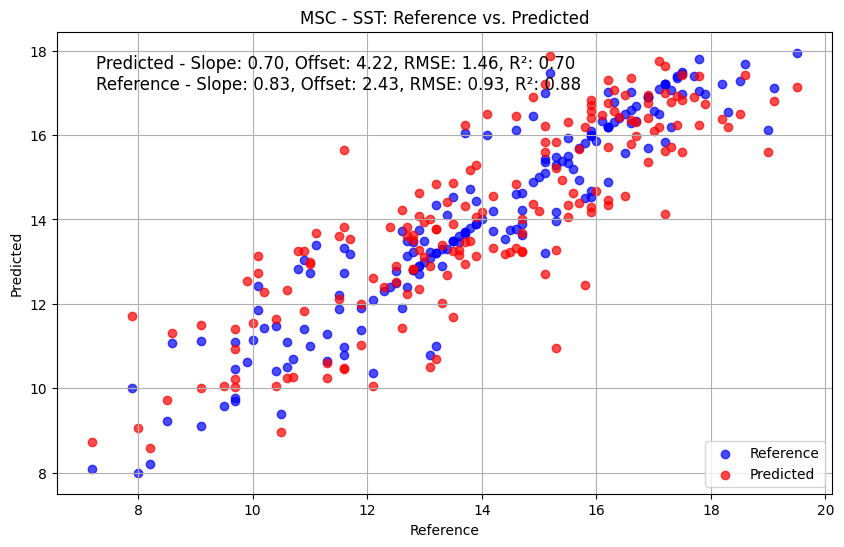

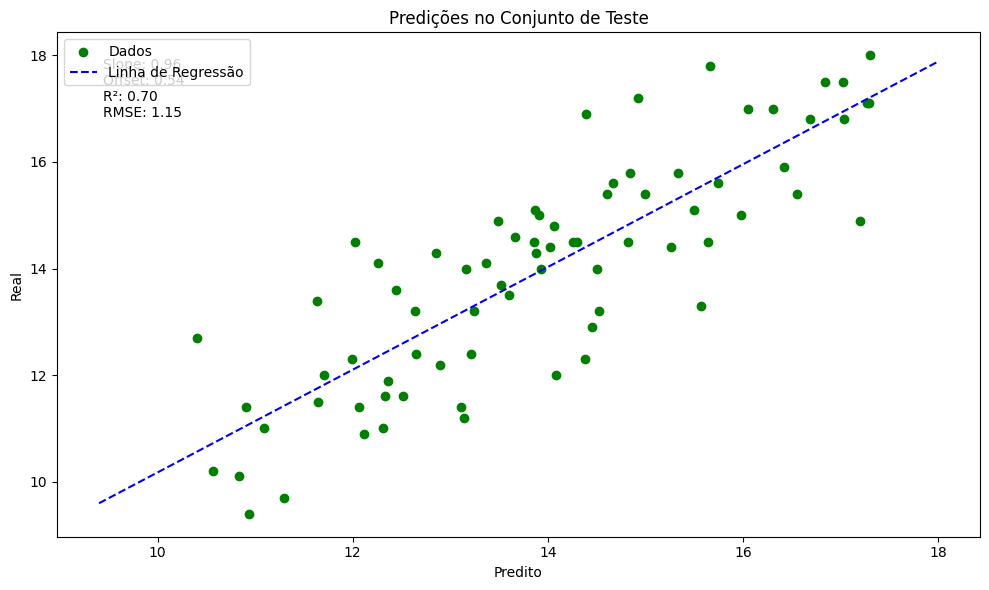

C:\Users\lenau\AppData\Local\Temp\ipykernel_7072\1584603334.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [7]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 6:], df_msc_cal['SST'].values, df_msc_val.iloc[:, 6:], df_msc_val['SST'].values, 'MSC', 'SST')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'SST')

c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


=== Training Metrics ===
R²: 0.7143
Correlation coefficient: 0.8457
RMSE: 0.3134
MAE: 0.0729
Relative absolute error: 16.1241
Root relative squared error: 53.4482
Slope: 0.9785
Offset: 0.0382


c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\U

=== Cross-Validation Metrics ===
R²: 0.3731
Correlation coefficient: 0.6410
RMSE: 0.4643
MAE: 0.2576
Relative absolute error: 57.0182
Root relative squared error: 79.1759
Slope: 0.7678
Offset: 0.2661
=== Validation Metrics ===
R²: 0.5038
Correlation coefficient: 0.7437
RMSE: 0.3081
MAE: 0.2198
Relative absolute error: 61.8005
Root relative squared error: 70.4429
Slope: 0.7702
Offset: 0.2558


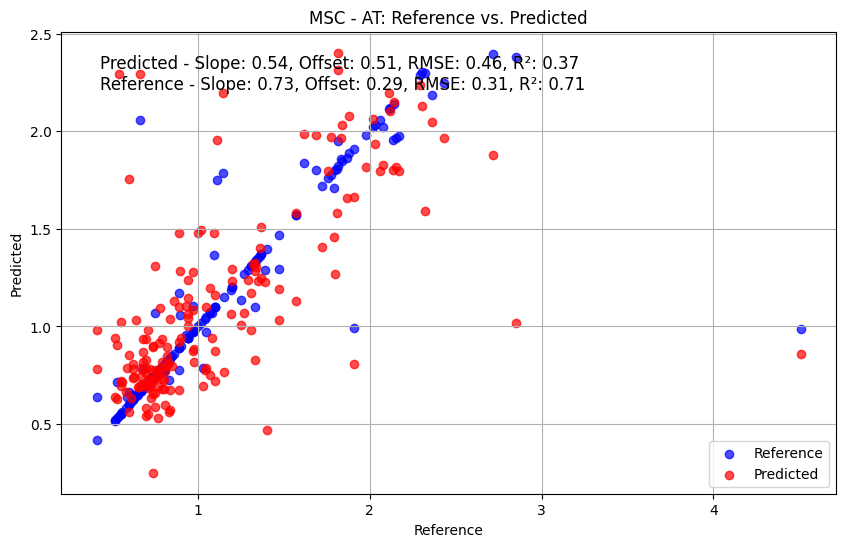

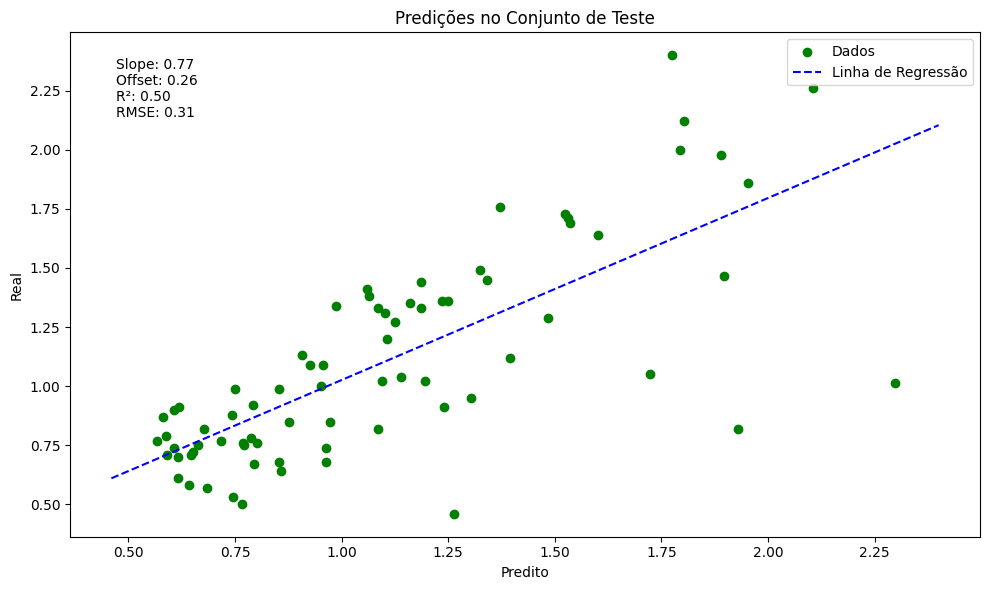

In [8]:
results_msc_at = SVM(df_msc_cal.iloc[:, 6:], df_msc_cal['AT'].values, df_msc_val.iloc[:, 6:], df_msc_val['AT'].values, 'MSC', 'AT')
infos_msc = add_plot_infos(infos_msc, results_msc_at, 'AT')

c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


=== Training Metrics ===
R²: 0.9197
Correlation coefficient: 0.9591
RMSE: 0.0874
MAE: 0.0209
Relative absolute error: 8.7130
Root relative squared error: 28.3454
Slope: 1.0091
Offset: -0.0263


c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\U

=== Cross-Validation Metrics ===
R²: 0.4119
Correlation coefficient: 0.6548
RMSE: 0.2365
MAE: 0.1434
Relative absolute error: 59.7964
Root relative squared error: 76.6861
Slope: 0.8344
Offset: 0.5448
=== Validation Metrics ===
R²: 0.2772
Correlation coefficient: 0.7000
RMSE: 0.2241
MAE: 0.1536
Relative absolute error: 65.1726
Root relative squared error: 85.0186
Slope: 0.6331
Offset: 1.2442


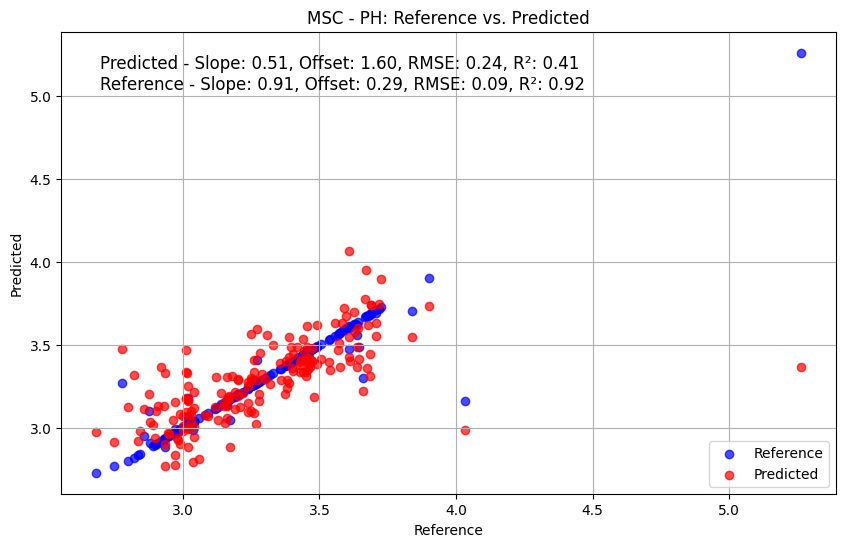

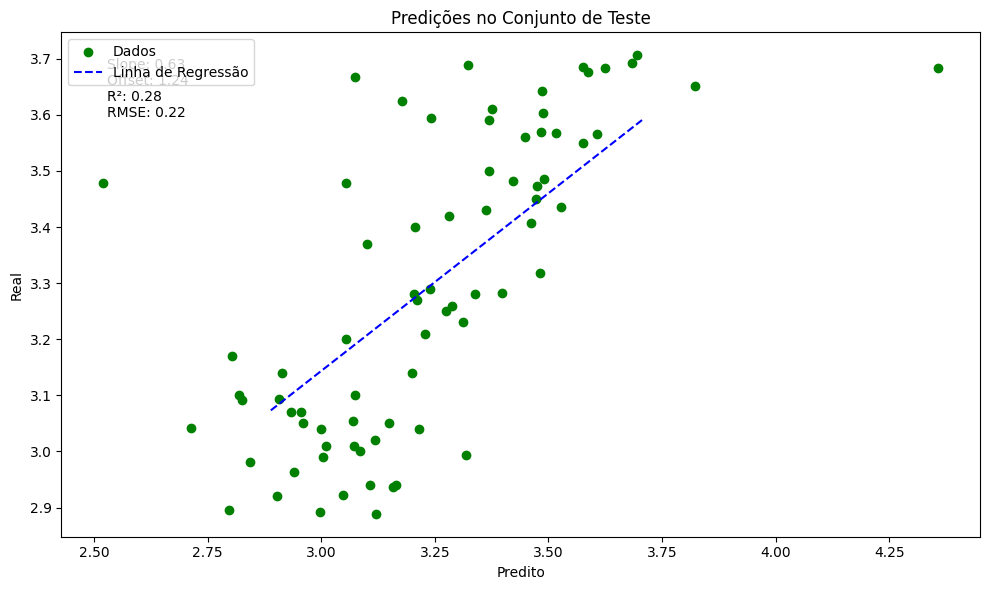

In [9]:
results_msc_ph = SVM(df_msc_cal.iloc[:, 6:], df_msc_cal['PH'].values, df_msc_val.iloc[:, 6:], df_msc_val['PH'].values, 'MSC', 'PH')
infos_msc = add_plot_infos(infos_msc, results_msc_ph, 'PH')

=== Training Metrics ===
R²: 0.3448
Correlation coefficient: 0.7155
RMSE: 83.1837
MAE: 66.3341
Relative absolute error: 79.6624
Root relative squared error: 80.9416
Slope: 2.3320
Offset: -685.9712
=== Cross-Validation Metrics ===
R²: 0.3111
Correlation coefficient: 0.6705
RMSE: 85.2980
MAE: 68.8258
Relative absolute error: 82.6547
Root relative squared error: 82.9989
Slope: 2.2461
Offset: -641.2668
=== Validation Metrics ===
R²: 0.3548
Correlation coefficient: 0.7051
RMSE: 62.0565
MAE: 50.6541
Relative absolute error: 79.8059
Root relative squared error: 80.3263
Slope: 1.9060
Offset: -480.5340


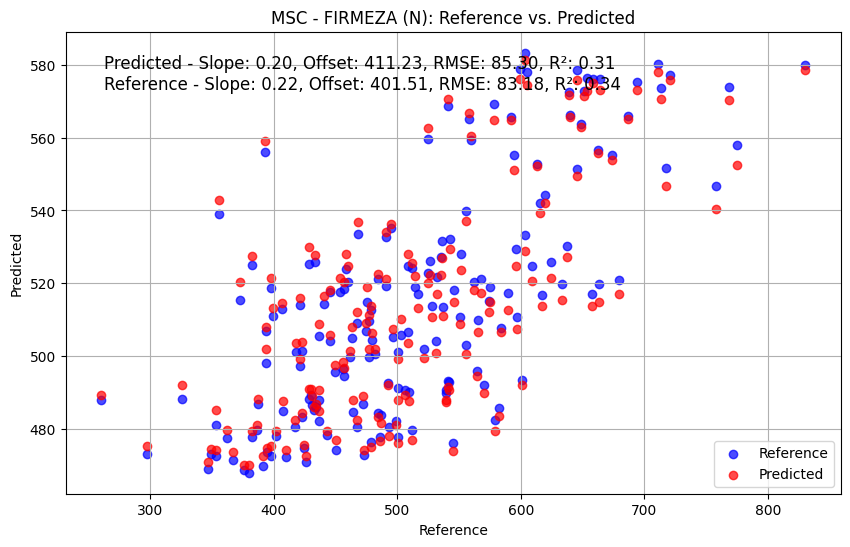

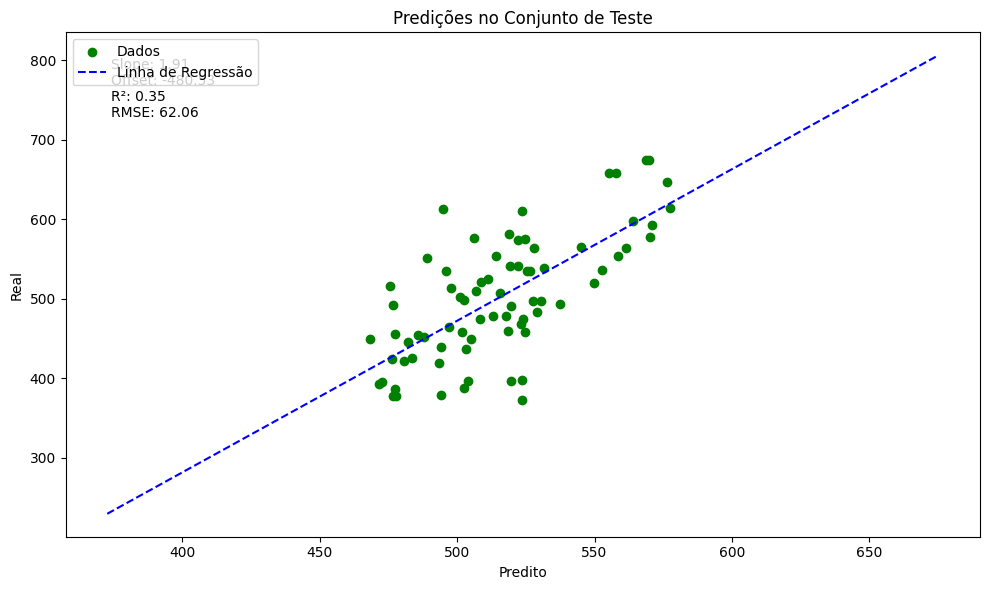

In [17]:
results_msc_firmeza = SVM(df_msc_cal.iloc[:, 6:], df_msc_cal['FIRMEZA (N)'].values, df_msc_val.iloc[:, 6:], df_msc_val['FIRMEZA (N)'].values, 'MSC', 'FIRMEZA (N)')
infos_msc = add_plot_infos(infos_msc, results_msc_firmeza, 'FIRMEZA (N)')


=== Training Metrics ===
R²: 0.7708
Correlation coefficient: 0.8817
RMSE: 1.5399
MAE: 0.6235
Relative absolute error: 25.2357
Root relative squared error: 47.8715
Slope: 1.0993
Offset: -1.4629
=== Cross-Validation Metrics ===
R²: 0.6492
Correlation coefficient: 0.8075
RMSE: 1.9053
MAE: 1.1376
Relative absolute error: 46.0460
Root relative squared error: 59.2302
Slope: 1.0663
Offset: -0.9467
=== Validation Metrics ===
R²: 0.7750
Correlation coefficient: 0.8821
RMSE: 1.0280
MAE: 0.8214
Relative absolute error: 46.2691
Root relative squared error: 47.4368
Slope: 0.9397
Offset: 0.9153


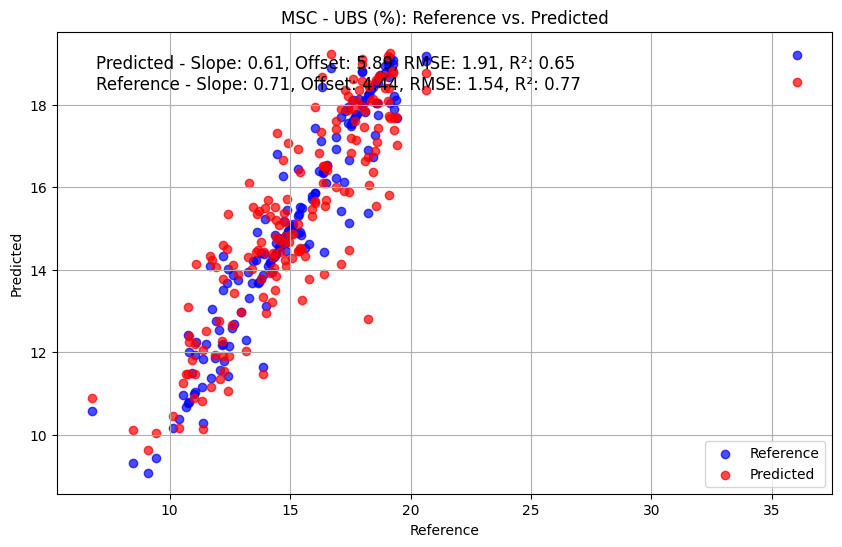

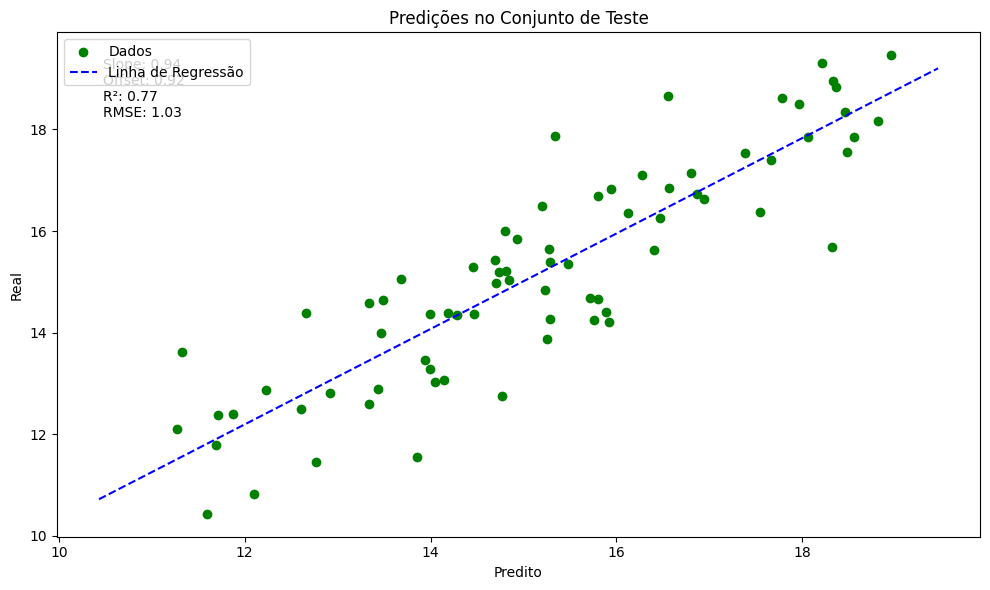

In [18]:
results_msc_ubs = SVM(df_msc_cal.iloc[:, 6:], df_msc_cal['UBS (%)'].values, df_msc_val.iloc[:, 6:], df_msc_val['UBS (%)'].values, 'MSC', 'UBS (%)')
infos_msc = add_plot_infos(infos_msc, results_msc_ubs, 'UBS (%)')

In [19]:
infos_msc.to_excel('plot_infos_SVM_msc.xlsx', index=False)
infos_msc

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.876609,0.937968,0.933113,0.610370,27.643880,35.127021,1.059340,-0.887731
1,SST,Cross-Validation,0.699115,0.836238,1.457112,1.170026,52.990920,54.852989,0.997989,-0.006961
2,SST,Validation,0.702073,0.838634,1.148603,0.924603,53.646213,54.582705,0.963173,0.543823
3,AT,Training,0.714329,0.845737,0.313432,0.072856,16.124060,53.448237,0.978480,0.038179
4,AT,Cross-Validation,0.373117,0.640975,0.464305,0.257634,57.018238,79.175943,0.767771,0.266148
5,AT,Validation,0.503779,0.743736,0.308104,0.219756,61.800523,70.442946,0.770170,0.255825
6,PH,Training,0.919654,0.959093,0.087423,0.020902,8.713011,28.345372,1.009094,-0.026315
7,PH,Cross-Validation,0.411924,0.654845,0.236516,0.143446,59.796402,76.686139,0.834430,0.544803
8,PH,Validation,0.277184,0.700000,0.224053,0.153569,65.172643,85.018611,0.633102,1.244247
9,FIRMEZA (N),Training,0.344846,0.715548,83.183666,66.334103,79.662365,80.941577,2.331963,-685.971156


# SNV - SVMR

=== Training Metrics ===
R²: 0.8803
Correlation coefficient: 0.9403
RMSE: 0.9004
MAE: 0.5542
Relative absolute error: 25.8872
Root relative squared error: 34.5933
Slope: 1.0654
Offset: -0.9674
=== Cross-Validation Metrics ===
R²: 0.7335
Correlation coefficient: 0.8570
RMSE: 1.3437
MAE: 1.0345
Relative absolute error: 48.3262
Root relative squared error: 51.6263
Slope: 1.0330
Offset: -0.5015
=== Validation Metrics ===
R²: 0.6999
Correlation coefficient: 0.8479
RMSE: 1.2308
MAE: 0.9801
Relative absolute error: 52.7305
Root relative squared error: 54.7848
Slope: 0.8691
Offset: 1.7501


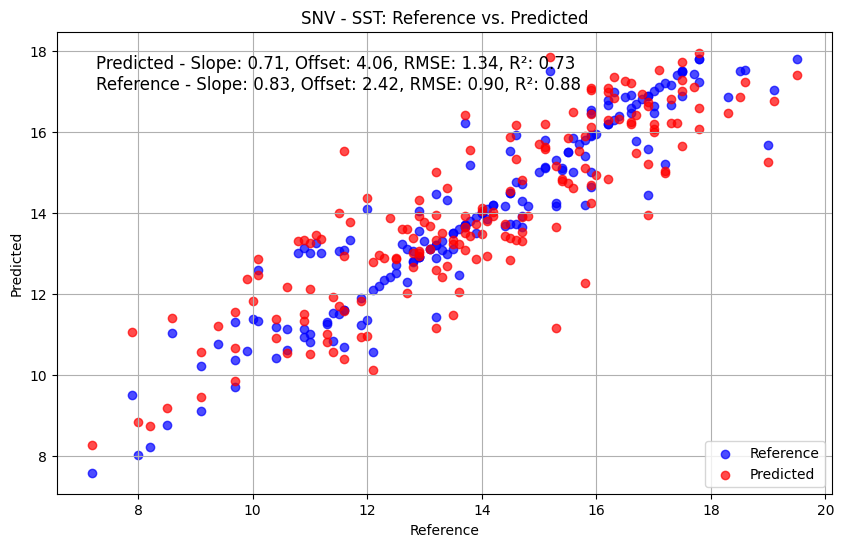

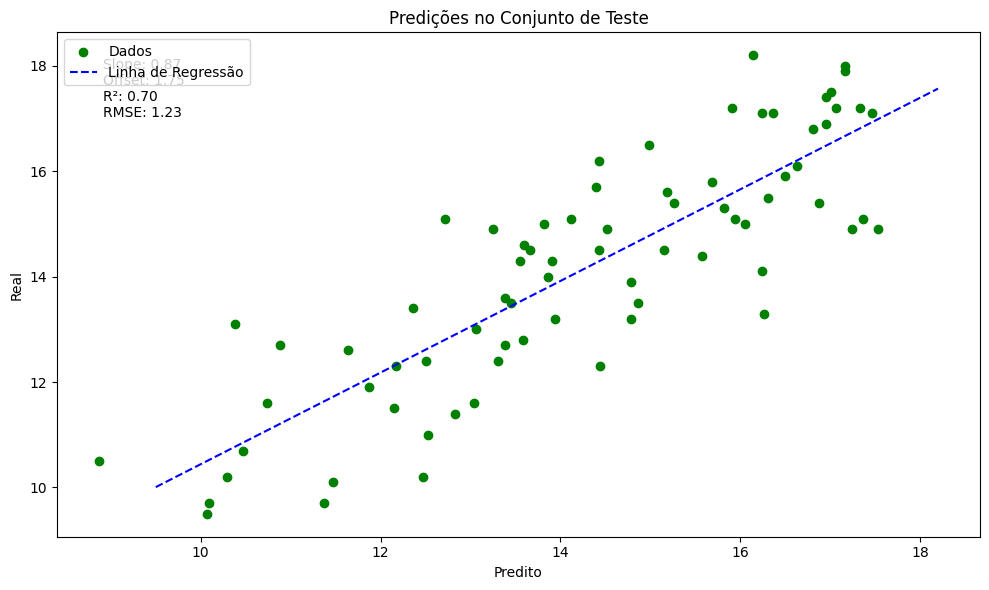

C:\Users\lenau\AppData\Local\Temp\ipykernel_7072\1584603334.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [20]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 6:], df_snv_cal['SST'].values, df_snv_val.iloc[:, 6:], df_snv_val['SST'].values, 'SNV', 'SST')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'SST')

c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


=== Training Metrics ===
R²: 0.7145
Correlation coefficient: 0.8458
RMSE: 0.2988
MAE: 0.0723
Relative absolute error: 17.1123
Root relative squared error: 53.4303
Slope: 0.9816
Offset: 0.0350


c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\U

=== Cross-Validation Metrics ===
R²: 0.3668
Correlation coefficient: 0.6366
RMSE: 0.4450
MAE: 0.2464
Relative absolute error: 58.3275
Root relative squared error: 79.5760
Slope: 0.7648
Offset: 0.2698
=== Validation Metrics ===
R²: 0.7061
Correlation coefficient: 0.8442
RMSE: 0.2784
MAE: 0.1776
Relative absolute error: 42.2499
Root relative squared error: 54.2163
Slope: 0.9372
Offset: 0.0408


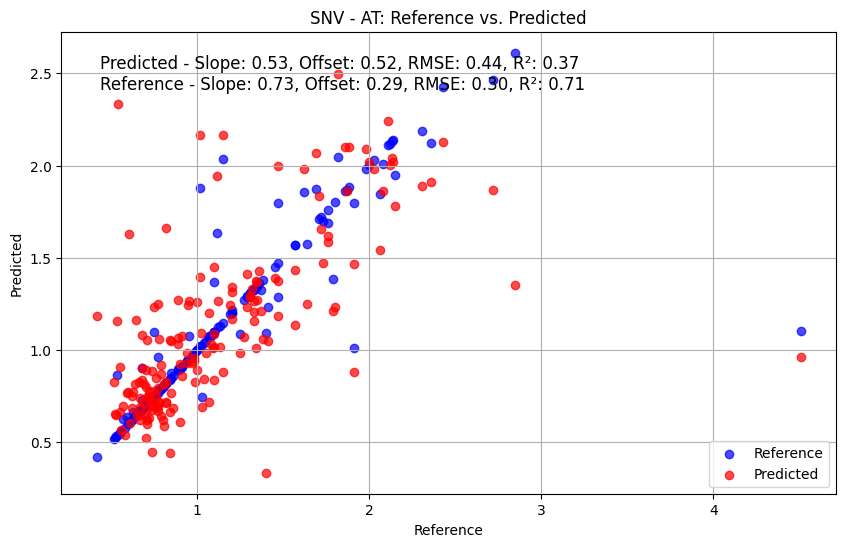

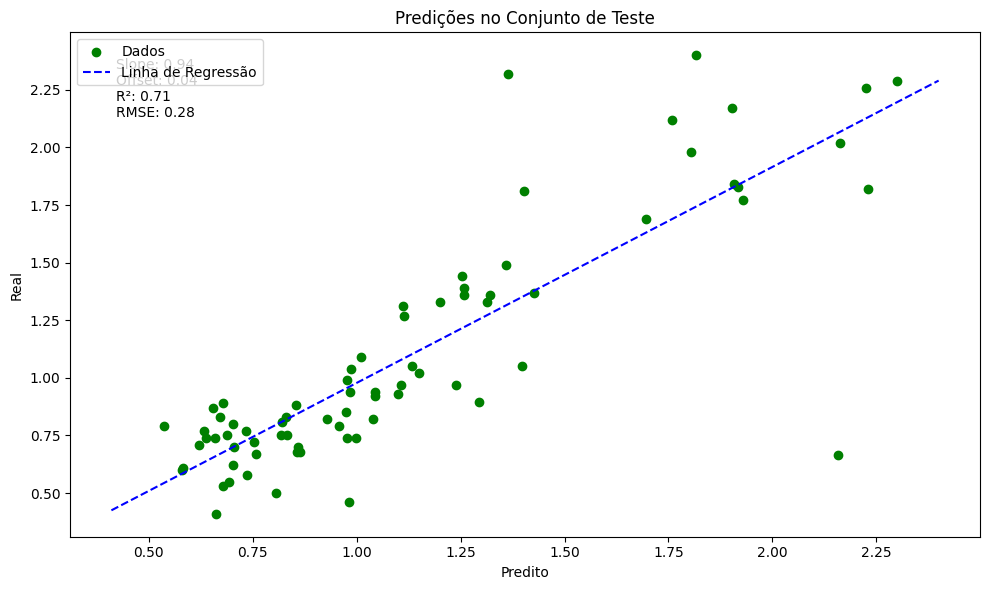

In [21]:
results_snv_at = SVM(df_snv_cal.iloc[:, 6:], df_snv_cal['AT'].values, df_snv_val.iloc[:, 6:], df_snv_val['AT'].values, 'SNV', 'AT')
infos_snv = add_plot_infos(infos_snv, results_snv_at, 'AT')

c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


=== Training Metrics ===
R²: 0.9093
Correlation coefficient: 0.9541
RMSE: 0.0943
MAE: 0.0256
Relative absolute error: 10.3024
Root relative squared error: 30.1246
Slope: 1.0312
Offset: -0.0975


c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lenau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\U

=== Cross-Validation Metrics ===
R²: 0.3583
Correlation coefficient: 0.6303
RMSE: 0.2508
MAE: 0.1604
Relative absolute error: 64.4991
Root relative squared error: 80.1061
Slope: 0.7618
Offset: 0.7895
=== Validation Metrics ===
R²: 0.6532
Correlation coefficient: 0.8230
RMSE: 0.1454
MAE: 0.1094
Relative absolute error: 51.6790
Root relative squared error: 58.8908
Slope: 0.8414
Offset: 0.5157


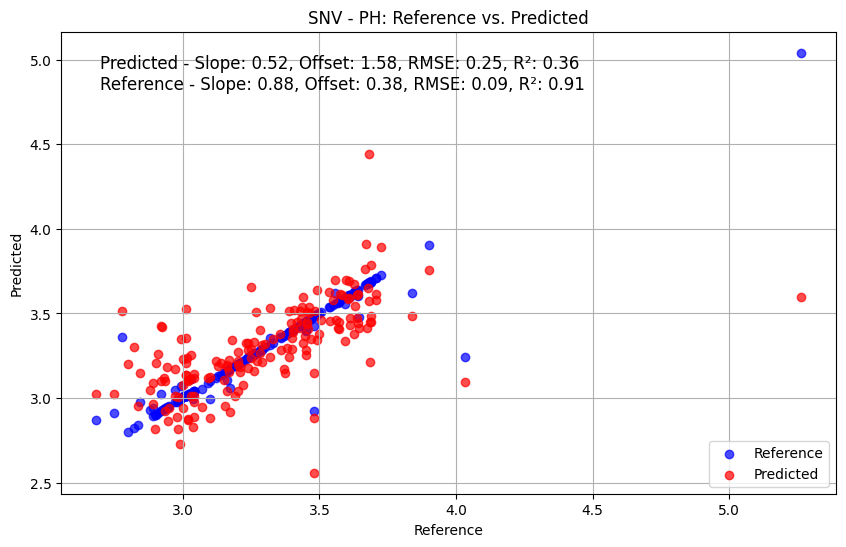

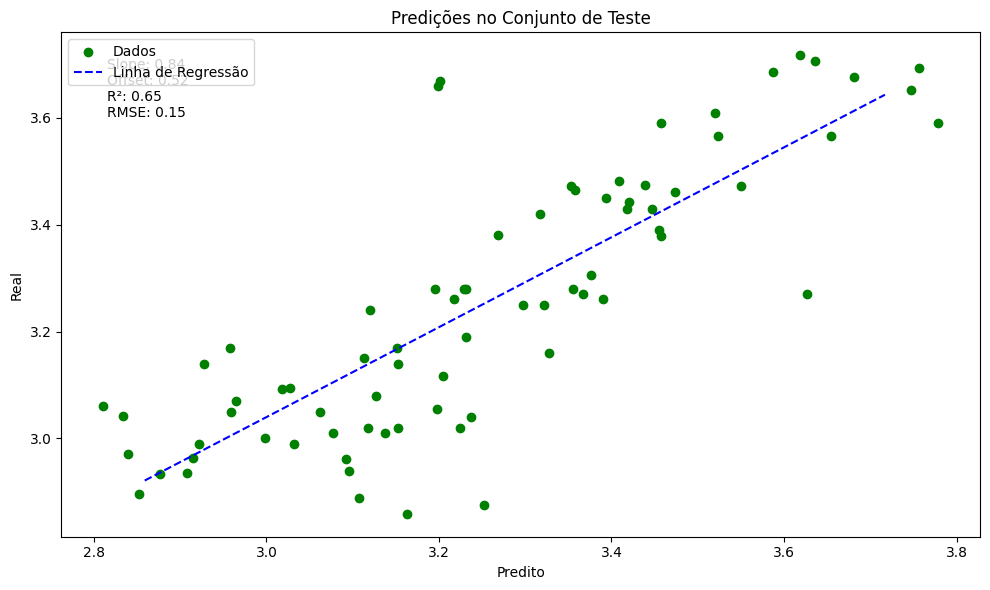

In [22]:
results_snv_ph = SVM(df_snv_cal.iloc[:, 6:], df_snv_cal['PH'].values, df_snv_val.iloc[:, 6:], df_snv_val['PH'].values, 'SNV', 'PH')
infos_snv = add_plot_infos(infos_snv, results_snv_ph, 'PH')

=== Training Metrics ===
R²: 0.3067
Correlation coefficient: 0.6841
RMSE: 84.1733
MAE: 65.8291
Relative absolute error: 81.3942
Root relative squared error: 83.2658
Slope: 2.4207
Offset: -733.4349
=== Cross-Validation Metrics ===
R²: 0.2776
Correlation coefficient: 0.6420
RMSE: 85.9197
MAE: 67.9398
Relative absolute error: 84.0039
Root relative squared error: 84.9934
Slope: 2.3318
Offset: -687.0147
=== Validation Metrics ===
R²: 0.4417
Correlation coefficient: 0.7923
RMSE: 61.1657
MAE: 53.2150
Relative absolute error: 79.3198
Root relative squared error: 74.7184
Slope: 2.0136
Offset: -533.4079


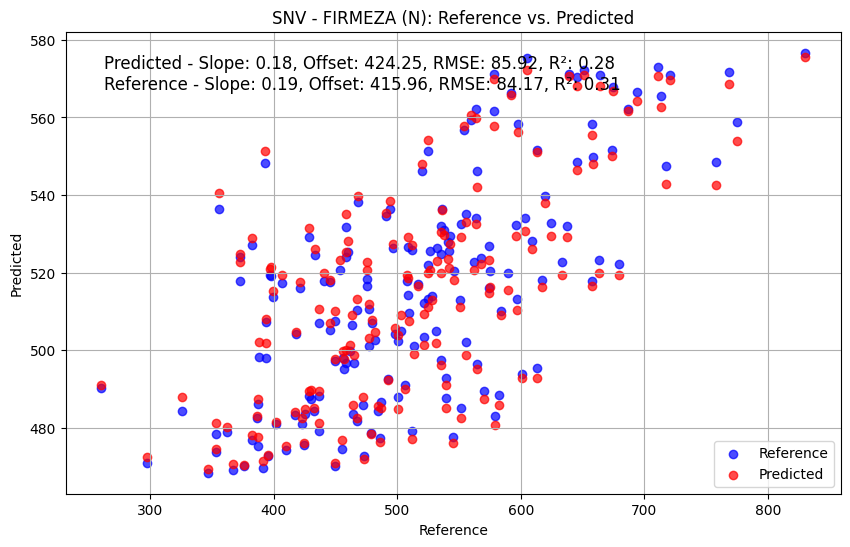

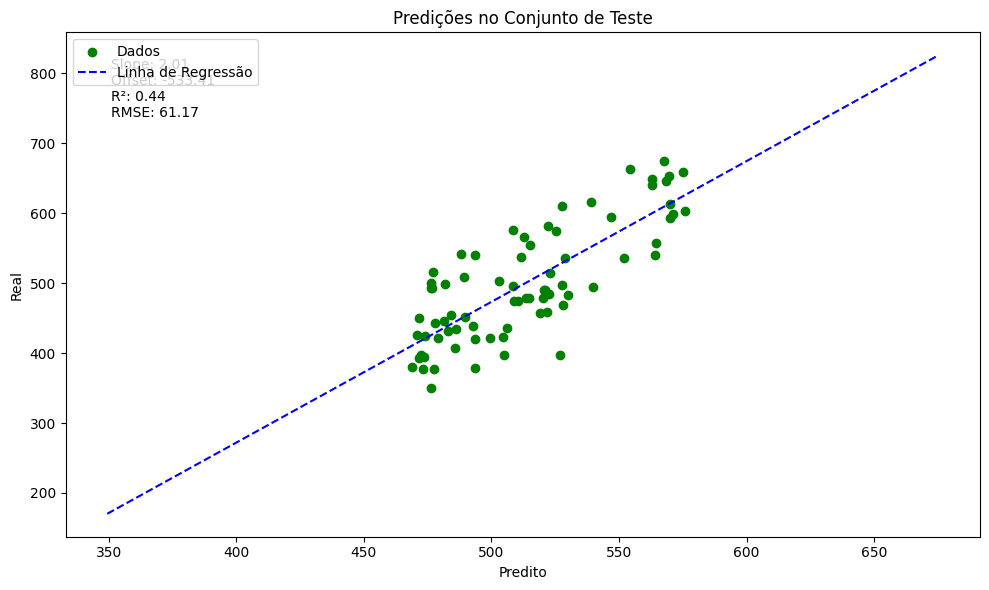

In [23]:
results_snv_firmeza = SVM(df_snv_cal.iloc[:, 6:], df_snv_cal['FIRMEZA (N)'].values, df_snv_val.iloc[:, 6:], df_snv_val['FIRMEZA (N)'].values, 'SNV', 'FIRMEZA (N)')
infos_snv = add_plot_infos(infos_snv, results_snv_firmeza, 'FIRMEZA (N)')

=== Training Metrics ===
R²: 0.7665
Correlation coefficient: 0.8820
RMSE: 1.5205
MAE: 0.5867
Relative absolute error: 24.6049
Root relative squared error: 48.3228
Slope: 1.1328
Offset: -1.9346
=== Cross-Validation Metrics ===
R²: 0.6618
Correlation coefficient: 0.8182
RMSE: 1.8299
MAE: 1.0472
Relative absolute error: 43.9164
Root relative squared error: 58.1557
Slope: 1.1113
Offset: -1.5917
=== Validation Metrics ===
R²: 0.7545
Correlation coefficient: 0.8751
RMSE: 1.1880
MAE: 0.9229
Relative absolute error: 46.7382
Root relative squared error: 49.5484
Slope: 0.8993
Offset: 1.4558


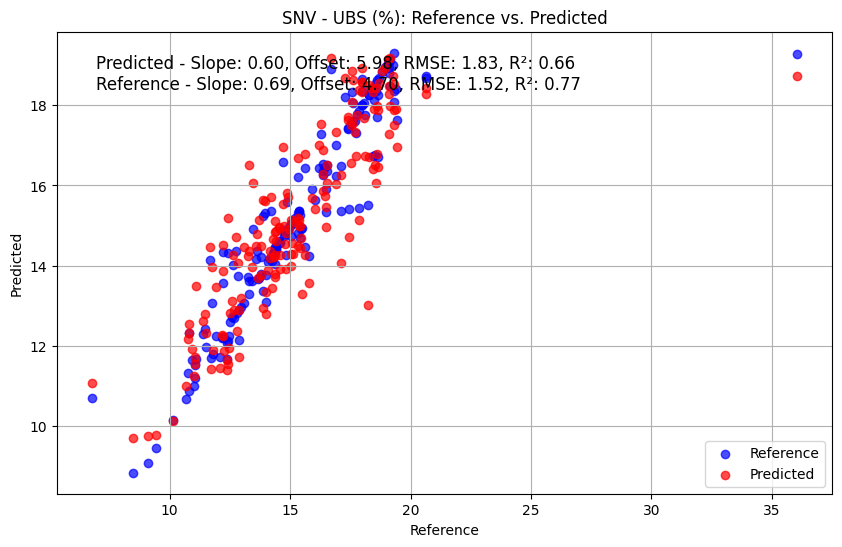

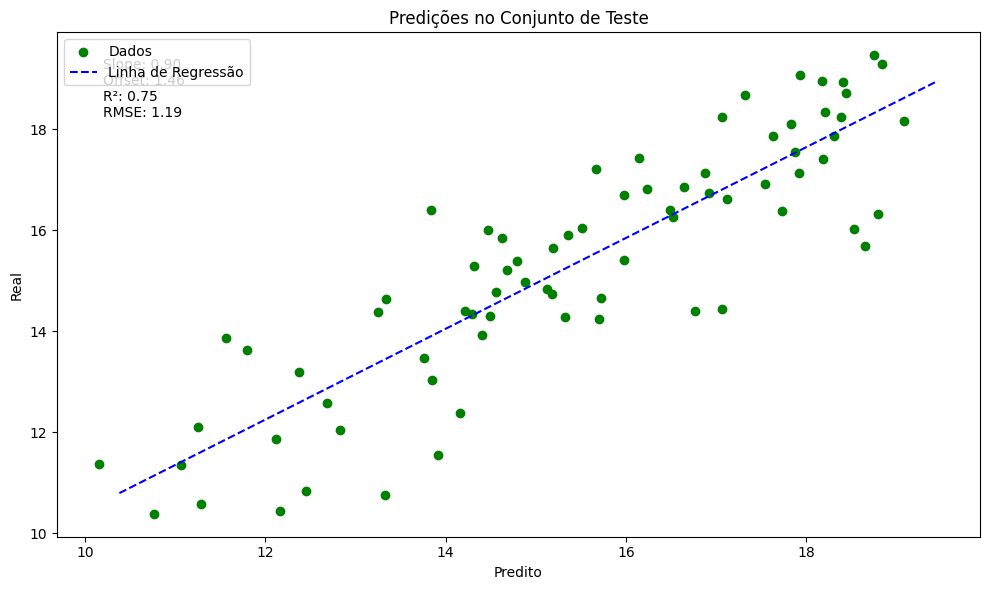

In [24]:
results_snv_ubs = SVM(df_snv_cal.iloc[:, 6:], df_snv_cal['UBS (%)'].values, df_snv_val.iloc[:, 6:], df_snv_val['UBS (%)'].values, 'SNV', 'UBS (%)')
infos_snv = add_plot_infos(infos_snv, results_snv_ubs, 'UBS (%)')

In [25]:
infos_snv.to_excel('plot_infos_SVM_snv.xlsx', index=False)
infos_snv

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.880331,0.940259,0.900383,0.554161,25.887178,34.593258,1.065391,-0.967413
1,SST,Cross-Validation,0.733473,0.857013,1.343714,1.034507,48.326204,51.626300,1.032982,-0.501499
2,SST,Validation,0.699863,0.847929,1.230769,0.980141,52.730518,54.784792,0.869069,1.750125
3,AT,Training,0.714520,0.845840,0.298771,0.072290,17.112334,53.430347,0.981598,0.034965
4,AT,Cross-Validation,0.366766,0.636583,0.444971,0.246402,58.327474,79.576016,0.764797,0.269850
5,AT,Validation,0.706059,0.844153,0.278447,0.177617,42.249933,54.216344,0.937191,0.040782
6,PH,Training,0.909251,0.954135,0.094332,0.025617,10.302415,30.124560,1.031187,-0.097458
7,PH,Cross-Validation,0.358301,0.630336,0.250844,0.160379,64.499073,80.106122,0.761786,0.789536
8,PH,Validation,0.653188,0.822958,0.145385,0.109404,51.679043,58.890777,0.841378,0.515735
9,FIRMEZA (N),Training,0.306681,0.684145,84.173274,65.829111,81.394182,83.265789,2.420744,-733.434878


# SG - SVMR

=== Training Metrics ===
R²: 0.9668
Correlation coefficient: 0.9838
RMSE: 0.4840
MAE: 0.2148
Relative absolute error: 9.7152
Root relative squared error: 18.2140
Slope: 1.0317
Offset: -0.4632
=== Cross-Validation Metrics ===
R²: 0.7300
Correlation coefficient: 0.8546
RMSE: 1.3807
MAE: 1.0631
Relative absolute error: 48.0750
Root relative squared error: 51.9607
Slope: 1.0211
Offset: -0.3164
=== Validation Metrics ===
R²: 0.6976
Correlation coefficient: 0.8429
RMSE: 1.1558
MAE: 0.9032
Relative absolute error: 52.6102
Root relative squared error: 54.9923
Slope: 0.8818
Offset: 1.6708


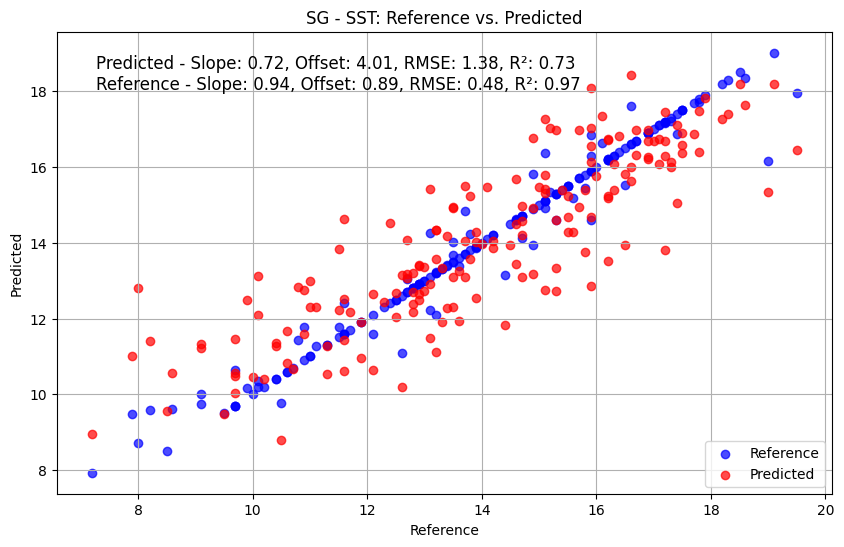

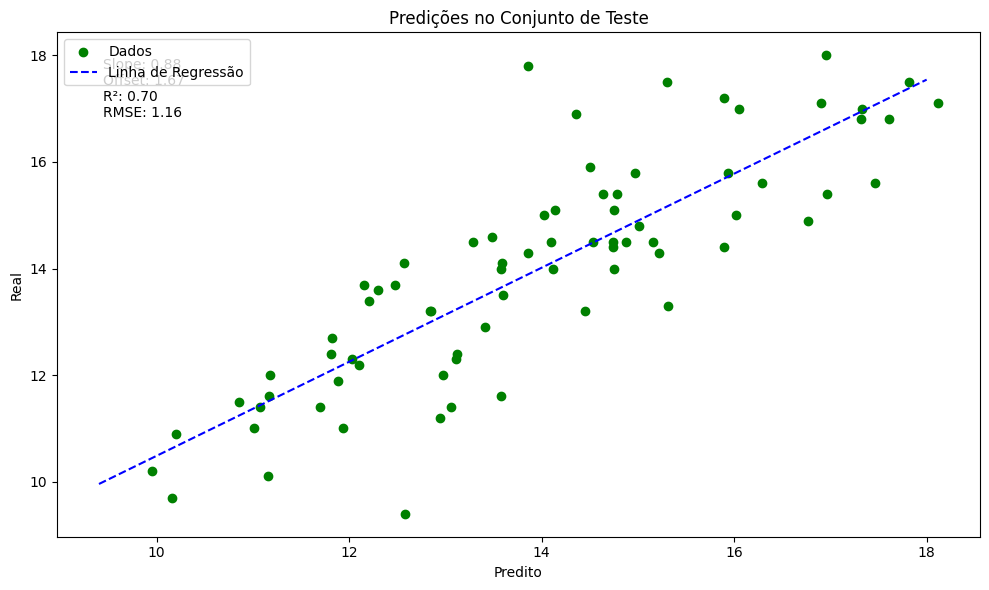

C:\Users\lenau\AppData\Local\Temp\ipykernel_7072\1584603334.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [11]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 6:], df_sg_cal['SST'].values, df_sg_val.iloc[:, 6:], df_sg_val['SST'].values, 'SG', 'SST')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'SST')

=== Training Metrics ===
R²: 0.8641
Correlation coefficient: 0.9305
RMSE: 0.2163
MAE: 0.0198
Relative absolute error: 4.3735
Root relative squared error: 36.8679
Slope: 1.0361
Offset: -0.0253
=== Cross-Validation Metrics ===
R²: 0.4692
Correlation coefficient: 0.6876
RMSE: 0.4274
MAE: 0.2517
Relative absolute error: 55.6239
Root relative squared error: 72.8594
Slope: 0.9251
Offset: 0.0968
=== Validation Metrics ===
R²: 0.6925
Correlation coefficient: 0.8343
RMSE: 0.2423
MAE: 0.1787
Relative absolute error: 50.5167
Root relative squared error: 55.4540
Slope: 0.9339
Offset: 0.0725


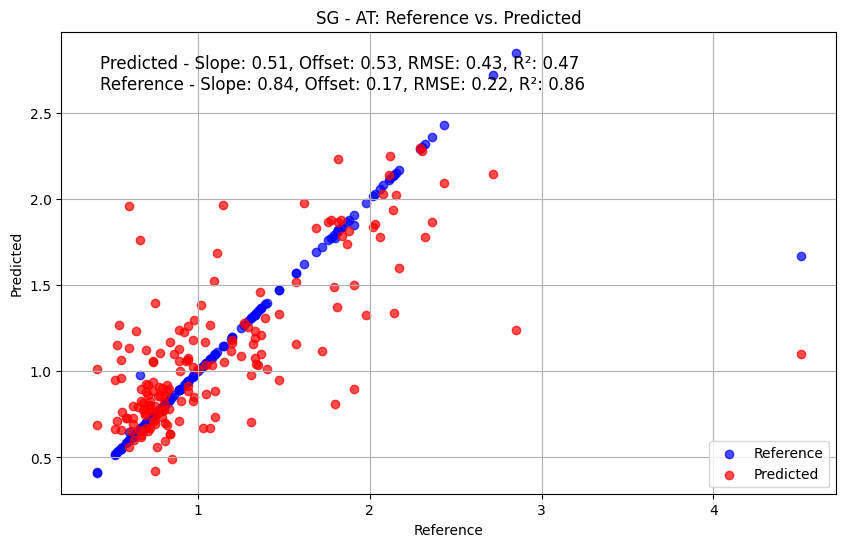

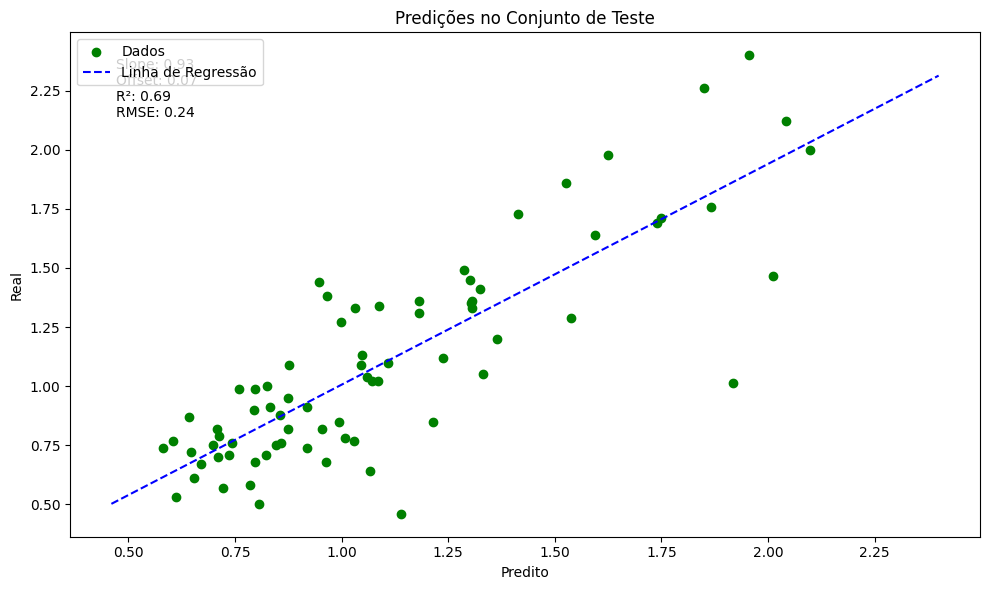

In [12]:
results_sg_at = SVM(df_sg_cal.iloc[:, 6:], df_sg_cal['AT'].values, df_sg_val.iloc[:, 6:], df_sg_val['AT'].values, 'SG', 'AT')
infos_sg = add_plot_infos(infos_sg, results_sg_at, 'AT')

=== Training Metrics ===
R²: 0.9944
Correlation coefficient: 0.9973
RMSE: 0.0231
MAE: 0.0031
Relative absolute error: 1.2836
Root relative squared error: 7.4768
Slope: 1.0112
Offset: -0.0347
=== Cross-Validation Metrics ===
R²: 0.4599
Correlation coefficient: 0.6782
RMSE: 0.2271
MAE: 0.1332
Relative absolute error: 55.4339
Root relative squared error: 73.4894
Slope: 1.0061
Offset: -0.0194
=== Validation Metrics ===
R²: 0.7044
Correlation coefficient: 0.8404
RMSE: 0.1423
MAE: 0.1039
Relative absolute error: 44.3304
Root relative squared error: 54.3691
Slope: 0.9636
Offset: 0.1276


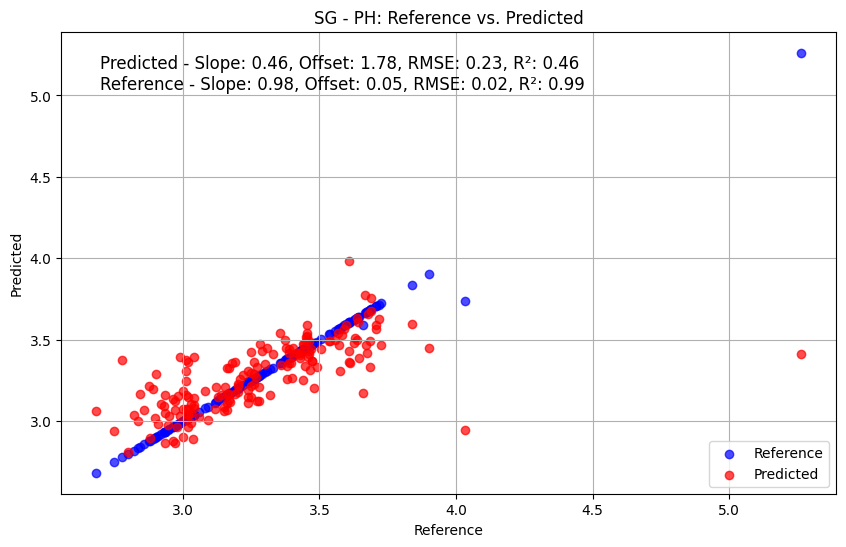

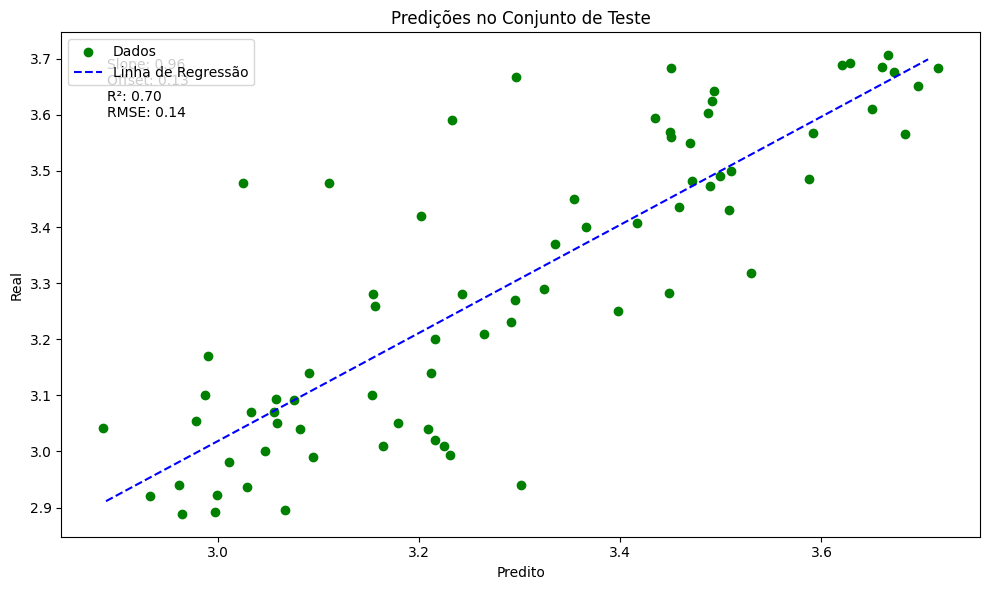

In [13]:
results_sg_ph = SVM(df_sg_cal.iloc[:, 6:], df_sg_cal['PH'].values, df_sg_val.iloc[:, 6:], df_sg_val['PH'].values, 'SG', 'PH')
infos_sg = add_plot_infos(infos_sg, results_sg_ph, 'PH')

=== Training Metrics ===
R²: 0.2208
Correlation coefficient: 0.7126
RMSE: 90.7174
MAE: 71.8130
Relative absolute error: 86.2391
Root relative squared error: 88.2708
Slope: 3.9463
Offset: -1486.0100
=== Cross-Validation Metrics ===
R²: 0.1762
Correlation coefficient: 0.6257
RMSE: 93.2763
MAE: 74.9347
Relative absolute error: 89.9880
Root relative squared error: 90.7607
Slope: 3.7680
Offset: -1395.4812
=== Validation Metrics ===
R²: 0.2539
Correlation coefficient: 0.6869
RMSE: 66.7259
MAE: 54.2926
Relative absolute error: 85.5478
Root relative squared error: 86.3750
Slope: 3.0611
Offset: -1050.0806


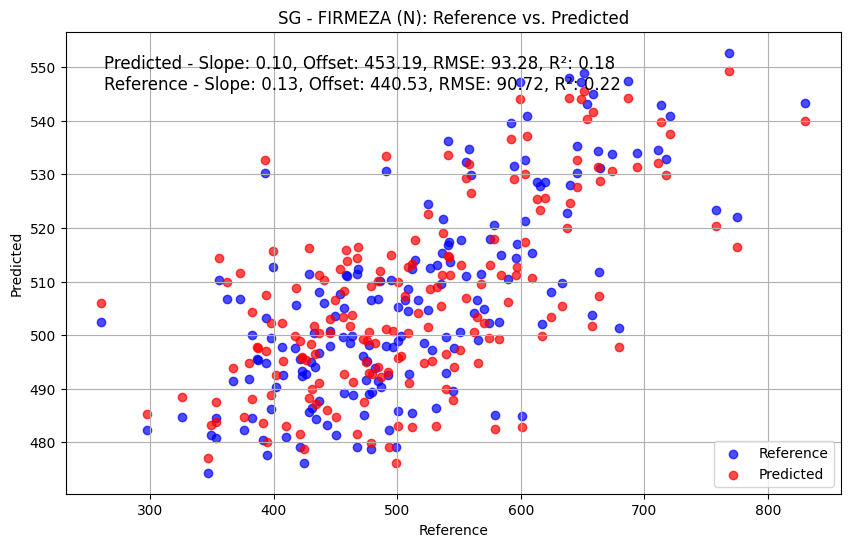

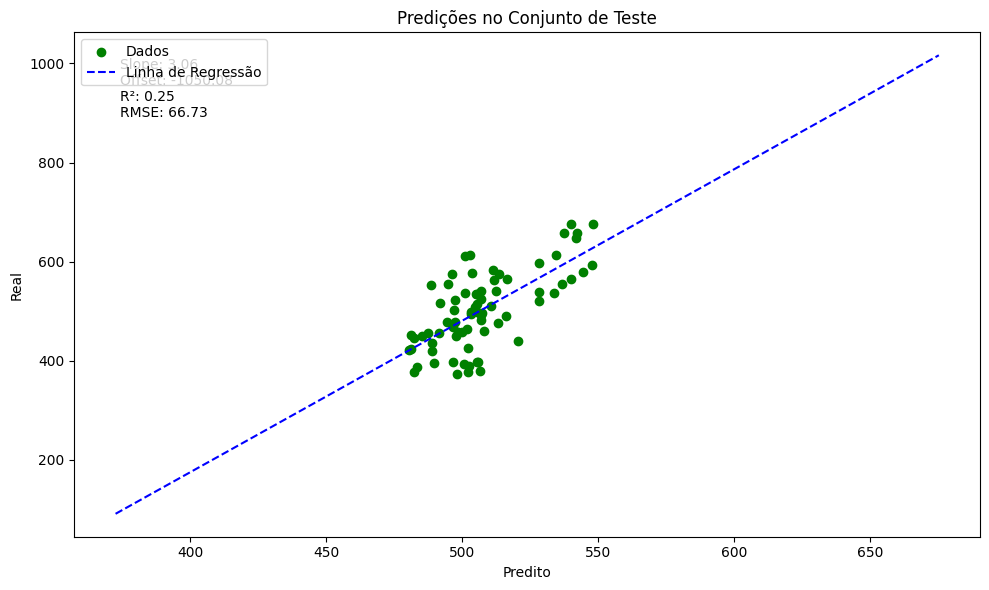

In [14]:
results_sg_firmeza = SVM(df_sg_cal.iloc[:, 6:], df_sg_cal['FIRMEZA (N)'].values, df_sg_val.iloc[:, 6:], df_sg_val['FIRMEZA (N)'].values, 'SG', 'FIRMEZA (N)')
infos_sg = add_plot_infos(infos_sg, results_sg_firmeza, 'FIRMEZA (N)')

=== Training Metrics ===
R²: 0.8398
Correlation coefficient: 0.9201
RMSE: 1.2876
MAE: 0.2737
Relative absolute error: 11.0834
Root relative squared error: 40.0308
Slope: 1.0976
Offset: -1.4521
=== Cross-Validation Metrics ===
R²: 0.6575
Correlation coefficient: 0.8149
RMSE: 1.8822
MAE: 1.1023
Relative absolute error: 44.6403
Root relative squared error: 58.5199
Slope: 1.1086
Offset: -1.6140
=== Validation Metrics ===
R²: 0.7880
Correlation coefficient: 0.8913
RMSE: 0.9979
MAE: 0.7763
Relative absolute error: 43.7516
Root relative squared error: 46.0479
Slope: 0.9237
Offset: 1.0944


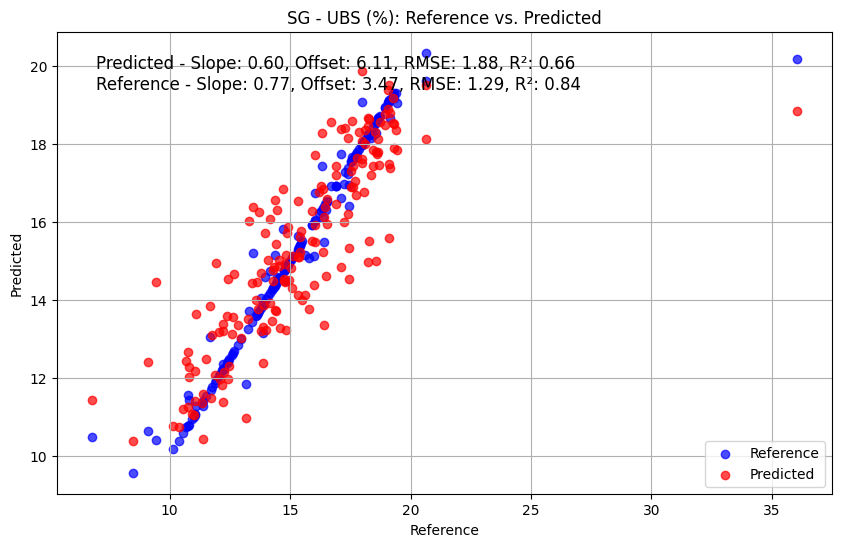

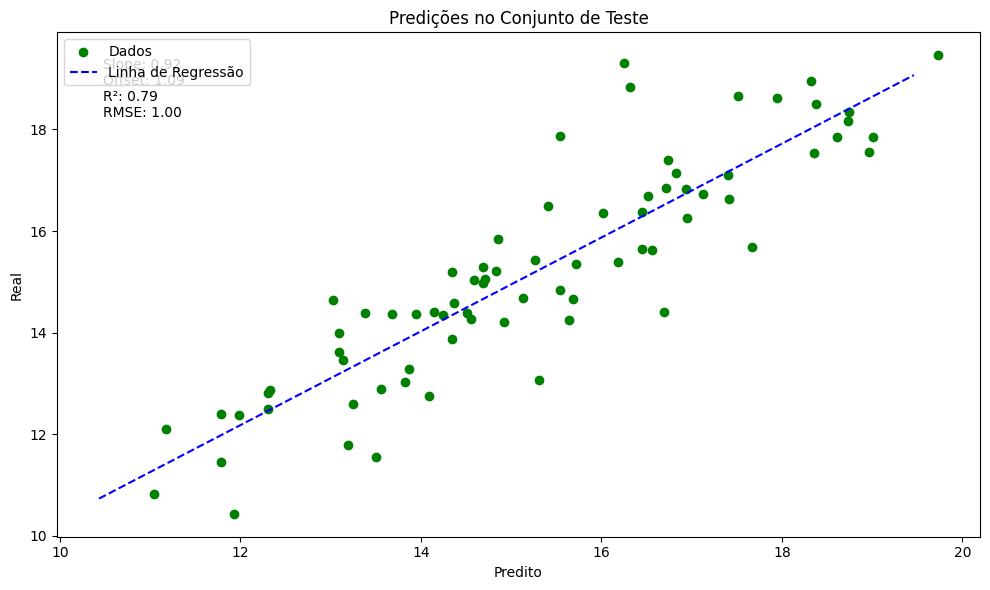

In [15]:
results_sg_ubs = SVM(df_sg_cal.iloc[:, 6:], df_sg_cal['UBS (%)'].values, df_sg_val.iloc[:, 6:], df_sg_val['UBS (%)'].values, 'SG', 'UBS (%)')
infos_sg = add_plot_infos(infos_sg, results_sg_ubs, 'UBS (%)')

In [16]:
infos_sg.to_excel('plot_infos_SVM_sg.xlsx', index=False)
infos_sg

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.966825,0.983763,0.483976,0.214847,9.715238,18.213954,1.031690,-0.463197
1,SST,Cross-Validation,0.730009,0.854624,1.380685,1.063150,48.074966,51.960696,1.021073,-0.316441
2,SST,Validation,0.697585,0.842899,1.155832,0.903213,52.610238,54.992260,0.881767,1.670755
3,AT,Training,0.864076,0.930458,0.216274,0.019792,4.373542,36.867920,1.036081,-0.025267
4,AT,Cross-Validation,0.469150,0.687609,0.427407,0.251726,55.623948,72.859431,0.925092,0.096822
5,AT,Validation,0.692485,0.834252,0.242274,0.178695,50.516719,55.453990,0.933870,0.072525
6,PH,Training,0.994410,0.997285,0.023100,0.003084,1.283571,7.476771,1.011207,-0.034692
7,PH,Cross-Validation,0.459931,0.678196,0.227054,0.133183,55.433867,73.489385,1.006062,-0.019437
8,PH,Validation,0.704401,0.840424,0.142301,0.103910,44.330415,54.369060,0.963616,0.127597
9,FIRMEZA (N),Training,0.220826,0.712646,90.717376,71.812966,86.239121,88.270819,3.946340,-1486.009961


# Testes

In [ ]:
X_test, y_test = df_msc_val.iloc[:,6:], df_msc_val['SST'].values
X_train, y_train = df_msc_cal.iloc[:,6:], df_msc_cal['SST'].values

In [ ]:
X_train.shape, X_test.shape

((175, 2151), (75, 2151))

In [ ]:
# Função para calcular as métricas
def calculate_metrics(y_true, y_pred):
    correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_y_true = np.mean(y_true)
    relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
    root_relative_squared_error = 100 * (rmse / np.std(y_true))

    return {
        "Correlation coefficient": correlation_coefficient,
        "Mean absolute error": mae,
        "Root mean squared error": rmse,
        "Relative absolute error": relative_absolute_error,
        "Root relative squared error": root_relative_squared_error,
        "Total Number of Instances": len(y_true)
    }

def display_metrics(title, metrics):
    print(f"\n=== {title} ===")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Configurações do modelo SVR com kernel RBF
model = SVR(
    C=1,                    # Regularização
    epsilon=1.0E-12,        # Tolerância
    kernel='poly',          # Kernel Polinomial
    degree=1,               # Grau do polinômio
    coef0=1,                # Termo de bias
    tol=0.001,              # Tolerância para precisão
    cache_size=250007,      # Tamanho do cache
    shrinking=True,         # Usar a heurística de shrinking
    verbose=False            # Exibir mensagens detalhadas
)
# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões no conjunto de treinamento
y_train_pred = model.predict(X_train)
training_metrics = calculate_metrics(y_train, y_train_pred)
display_metrics("Training Metrics", training_metrics)

# Validação cruzada Leave-One-Out (LOO)
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
y_train_cv = cross_val_predict(model, X_train, y_train, cv=loo)
cv_metrics = calculate_metrics(y_train, y_train_cv)
display_metrics("Cross-Validation Metrics", cv_metrics)

# Avaliação final no conjunto de teste
y_pred_val = model.predict(X_test)
validation_metrics = calculate_metrics(y_test, y_pred_val)
display_metrics("Validation Metrics", validation_metrics)


=== Training Metrics ===
Correlation coefficient: 0.6075
Mean absolute error: 1.9977
Root mean squared error: 2.4122
Relative absolute error: 90.4784
Root relative squared error: 90.8090
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.5444
Mean absolute error: 2.0478
Root mean squared error: 2.4530
Relative absolute error: 92.7471
Root relative squared error: 92.3443
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.5055
Mean absolute error: 1.5399
Root mean squared error: 1.9278
Relative absolute error: 89.3475
Root relative squared error: 91.6123
Total Number of Instances: 75.0000


In [ ]:
# Definir o pipeline
pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf'))

# Definir os parâmetros para o GridSearch
param_grid = {
    'svr__C': [0.1, 1,4],  # Valores de regularização
    'svr__gamma': ['auto', 0.1, 0.01, 0.001],  # Parâmetro gamma
    'svr__epsilon': [0.001, 1.0E-8,1.0E-12],  # Epsilon para a função de perda
    'svr__tol': [1e-3, 1e-4, 1e-5],  # Tolerância para critério de parada
    'svr__max_iter': [1000, 10000, -1],  # Número máximo de iterações (-1 para ilimitado)
}


# Definir o GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Usando MAE como métrica de avaliação
    cv=175,  # Validação cruzada com 5 folds
    n_jobs=-1,  # Utiliza todos os processadores disponíveis
    verbose=3  # Mostra detalhes do processo
)

# Treinar o GridSearchCV
grid_search.fit(X_train, y_train)

# Resultados do GridSearch
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Fazer previsões no conjunto de teste usando o melhor modelo encontrado
y_pred = grid_search.predict(X_test)

# Calcular e exibir as métricas de desempenho
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nResultados no conjunto de teste:")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")


Fitting 175 folds for each of 324 candidates, totalling 56700 fits
Melhores parâmetros encontrados:
{'svr__C': 4, 'svr__epsilon': 0.001, 'svr__gamma': 'auto', 'svr__max_iter': 1000, 'svr__tol': 0.0001}

Resultados no conjunto de teste:
MAE (Mean Absolute Error): 0.9246
RMSE (Root Mean Squared Error): 1.1486
R² (Coeficiente de Determinação): 0.7021
